In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pymc as pm
import numpyro

numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from bayesinsight import BayesInsightModel

In [13]:
def plot_posterior(posterior) -> plt.axes:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    pm.plot_posterior(posterior, ax=ax[0])
    pm.plot_posterior(posterior, ax=ax[1], kind="kde")
    return ax

In [4]:
model = BayesInsightModel.load("./test_model")

In [5]:
model.variable_details

[LocalTrendsVariableDetails(variable_name='LLT', variable_type='localtrend', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, std=None, mean=None, time_transform=None, sign=None, partial_pooling_sigma=0.1, num_knots=6, order=3, random_coeff_dims=[], llt_prior=LocalTrendPrior(type='LocalTrend', variability=0.1, group_variablility=0.01, partial_pooling=0.01, initial_dist_var=0.01), grouping_map=None, grouping_name=None),
 SeasonVariableDetails(variable_name='annual_seasonality', variable_type='season', deterministic_transform=DeterministicTransform(functional_form=<FunctionalForms.linear: 'linear'>, params=None), normalization=<Normilization.none: 'none'>, std=None, mean=None, time_transform=None, sign=None, partial_pooling_sigma=0.1, n_fourier=3, period=52.17857142857143, coeff_prior=SeasonPrior(coeff_dist=<Distribution.normal: 'Normal'>, coeff_params={'mu': 0.0, 'sigma': 0.1}, ty

In [6]:
prior = model.get_prior_predictive()

/home/mattr/Scratch/BayesInsight/bayesinsight/models/model.py:263: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas, LLT_LLT::splines_betas_sd, LLT_LLT::tau, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Stock_Total_Total_Total_alpha, Stock_Total_Total_Total_likelihood, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff, annual_seasonality_0_rand_coeff_sigma, annual_seasonality_1_fixed_coeff, annual_seasonality_1_rand_coeff, annual_seasonality_1_rand_coeff_sigma, annual_seasonality_2_fixed_coeff, annual_seasonality_2_rand_coeff, annual_seasonality_2_rand_coeff_sigma, annual_seasonality_3_fixed_coeff, annual_seasonality_3_rand_coeff, annual_seasonality_3_rand_coeff_sigma, annual_

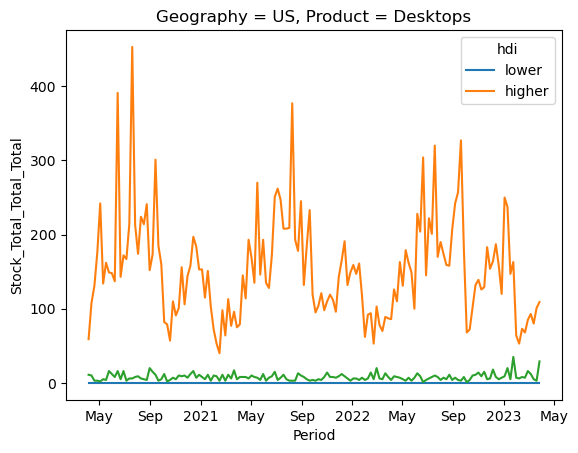

In [7]:
pm.hdi(prior.prior_predictive).sel(Geography="US", Product="Desktops")[
    "Stock_Total_Total_Total_likelihood"
].plot.line(x="Period")
exog_var = model.return_exog_variables()[0]
exog_var.as_xarray(model.data).sel(Geography="US", Product="Desktops").plot.line(
    x="Period"
)

In [8]:
model.fit(draws=1000, tune=1000, cores=4, overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_fixed_coeff, intercept_rand_coeff_sigma, intercept_rand_coeff, media_var_0_Total_Total_Total_fixed_coeff, media_var_0_Total_Total_Total_K_, media_var_0_Total_Total_Total_n_, media_var_0_Total_Total_Total_retention_rate_log, media_var_0_Total_Total_Total_lag, LLT_LLT::tau, LLT_LLT::splines_beta_mu, LLT_LLT::splines_betas_sd, LLT_LLT::splines_betas, Promotion_Total_Total_Total_fixed_coeff, Promotion_Total_Total_Total_rand_coeff_sigma, Promotion_Total_Total_Total_rand_coeff, annual_seasonality_0_fixed_coeff, annual_seasonality_0_rand_coeff_sigma, annual_seasonality_0_rand_coeff, annual_seasonality_1_fixed_coeff, annual_seasonality_1_rand_coeff_sigma, annual_seasonality_1_rand_coeff, annual_seasonality_2_fixed_coeff, annual_seasonality_2_rand_coeff_sigma, annual_seasonality_2_rand_coeff, annual_seasonality_3_fixed_coeff, annual_seasonality_3_rand_coeff_sig

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2795 seconds.
There were 1272 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1272 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [17]:
pm.summary(model.trace, var_names=["LLT_LLT::splines_betas"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
LLT_LLT::splines_betas[0],0.001,0.014,-0.022,0.029,0.001,0.000,518.0,648.0,1.04
LLT_LLT::splines_betas[1],-0.003,0.043,-0.091,0.075,0.002,0.001,457.0,675.0,1.07
LLT_LLT::splines_betas[2],-0.054,0.045,-0.143,0.027,0.002,0.002,379.0,597.0,1.02
LLT_LLT::splines_betas[3],-0.026,0.038,-0.099,0.047,0.002,0.002,344.0,638.0,1.07
LLT_LLT::splines_betas[4],0.042,0.040,-0.031,0.117,0.004,0.003,90.0,662.0,1.04
LLT_LLT::splines_betas[5],0.003,0.042,-0.075,0.082,0.003,0.002,288.0,420.0,1.01
LLT_LLT::splines_betas[6],-0.029,0.037,-0.104,0.037,0.002,0.001,306.0,673.0,1.02
LLT_LLT::splines_betas[7],-0.022,0.042,-0.104,0.053,0.003,0.002,236.0,537.0,1.07
LLT_LLT::splines_betas[8],0.013,0.041,-0.064,0.094,0.002,0.002,287.0,670.0,1.02
LLT_LLT::splines_betas[9],0.017,0.040,-0.053,0.101,0.002,0.002,421.0,752.0,1.03


In [14]:
plot_posterior(model.trace)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [11]:
model.save("./test_model_1")

In [12]:
constant_data = model.trace.constant_data

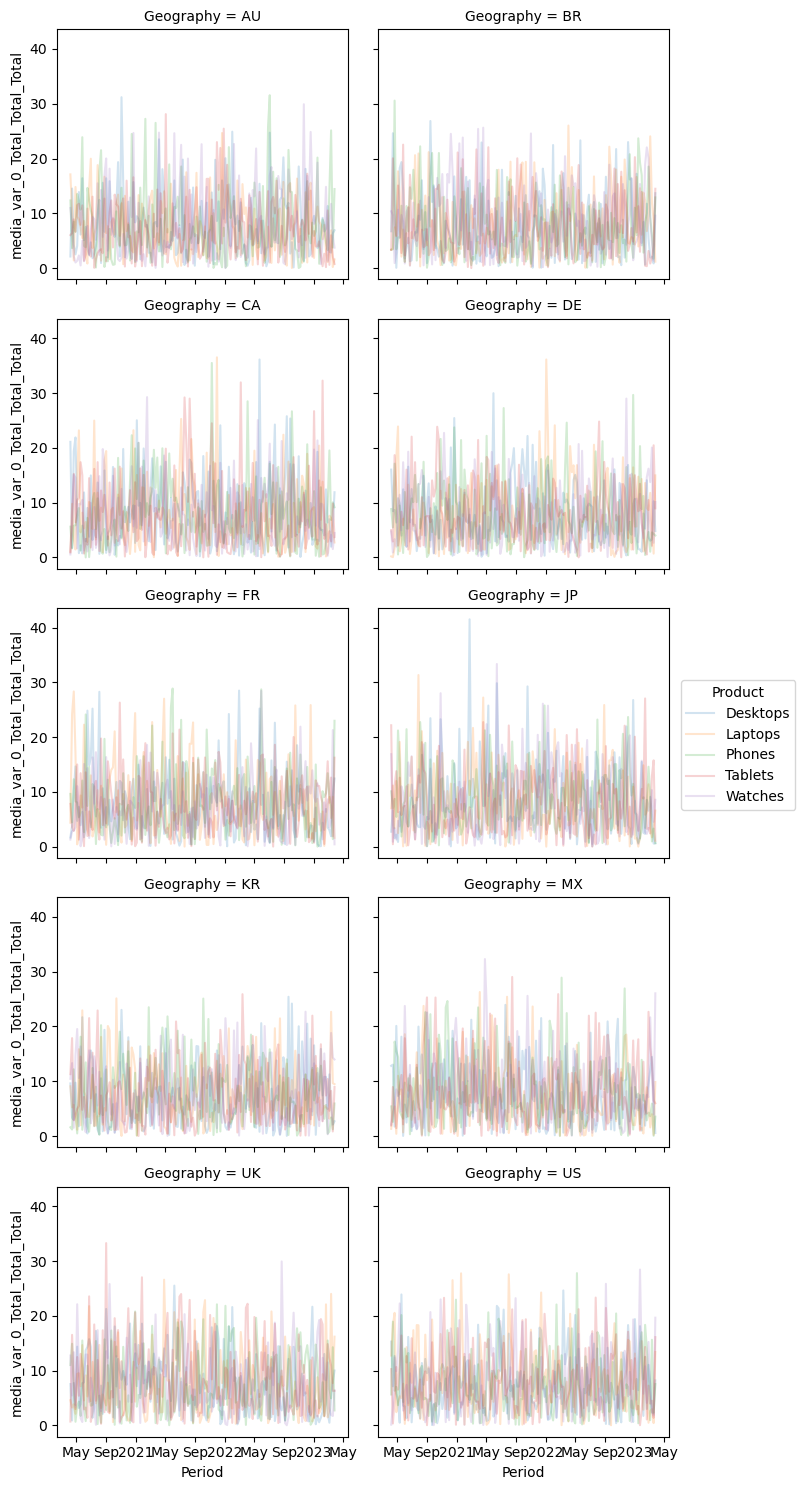

In [13]:
constant_data.media_var_0_Total_Total_Total.plot.line(
    x="Period", hue="Product", col="Geography", col_wrap=2, alpha=0.2
)

In [14]:
[var.variable_name for var in model.return_media_variables()]

['media_var_0_Total_Total_Total']

In [15]:
prediction = model.predict(subset={"chain": slice(0, 1), "draw": slice(0, 1000, 5)})

Output()

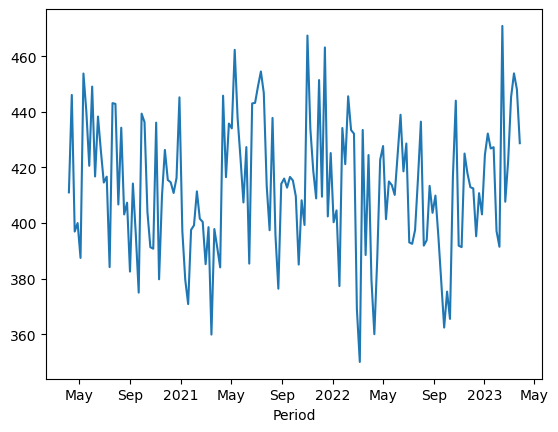

In [23]:
# prediction.LLT_contribution.mean(dim=("chain", "draw", "Geography", "Product")).plot.line(x='Period')
# prediction.annual_seasonality_contribution.mean(dim=("Geography", "Product")).mean(dim=("chain", "draw")).plot.line(x='Period')
np.exp(
    prediction.annual_seasonality_contribution
    + prediction.LLT_contribution
    + prediction.intercept_contribution
    + prediction.Promotion_Total_Total_Total_contribution
    + prediction.media_var_0_Total_Total_Total_contribution
).sum(dim=("Geography", "Product")).mean(dim=("chain", "draw")).plot.line(x="Period")

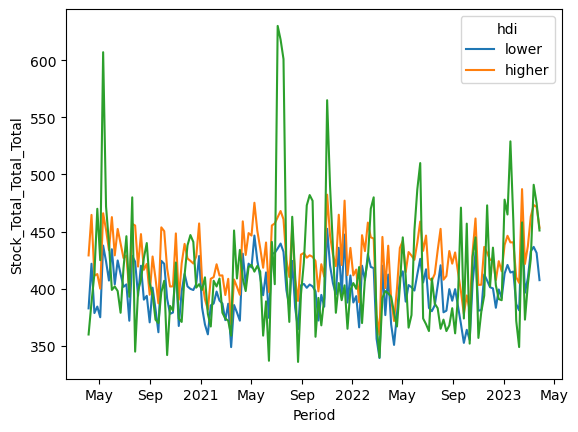

In [14]:
pm.hdi(prediction.mu.sum(dim=("Geography", "Product")))["mu"].plot.line(x="Period")
# pm.hdi(posterior.posterior_predictive.Stock_Total_Total_Total_likelihood.sum(dim=("Geography", "Product")))['Stock_Total_Total_Total_likelihood'].plot.line(x='Period')
exog_var = model.return_exog_variables()[0]
exog_var.as_xarray(model.data).sum(dim=("Geography", "Product")).plot.line(x="Period")

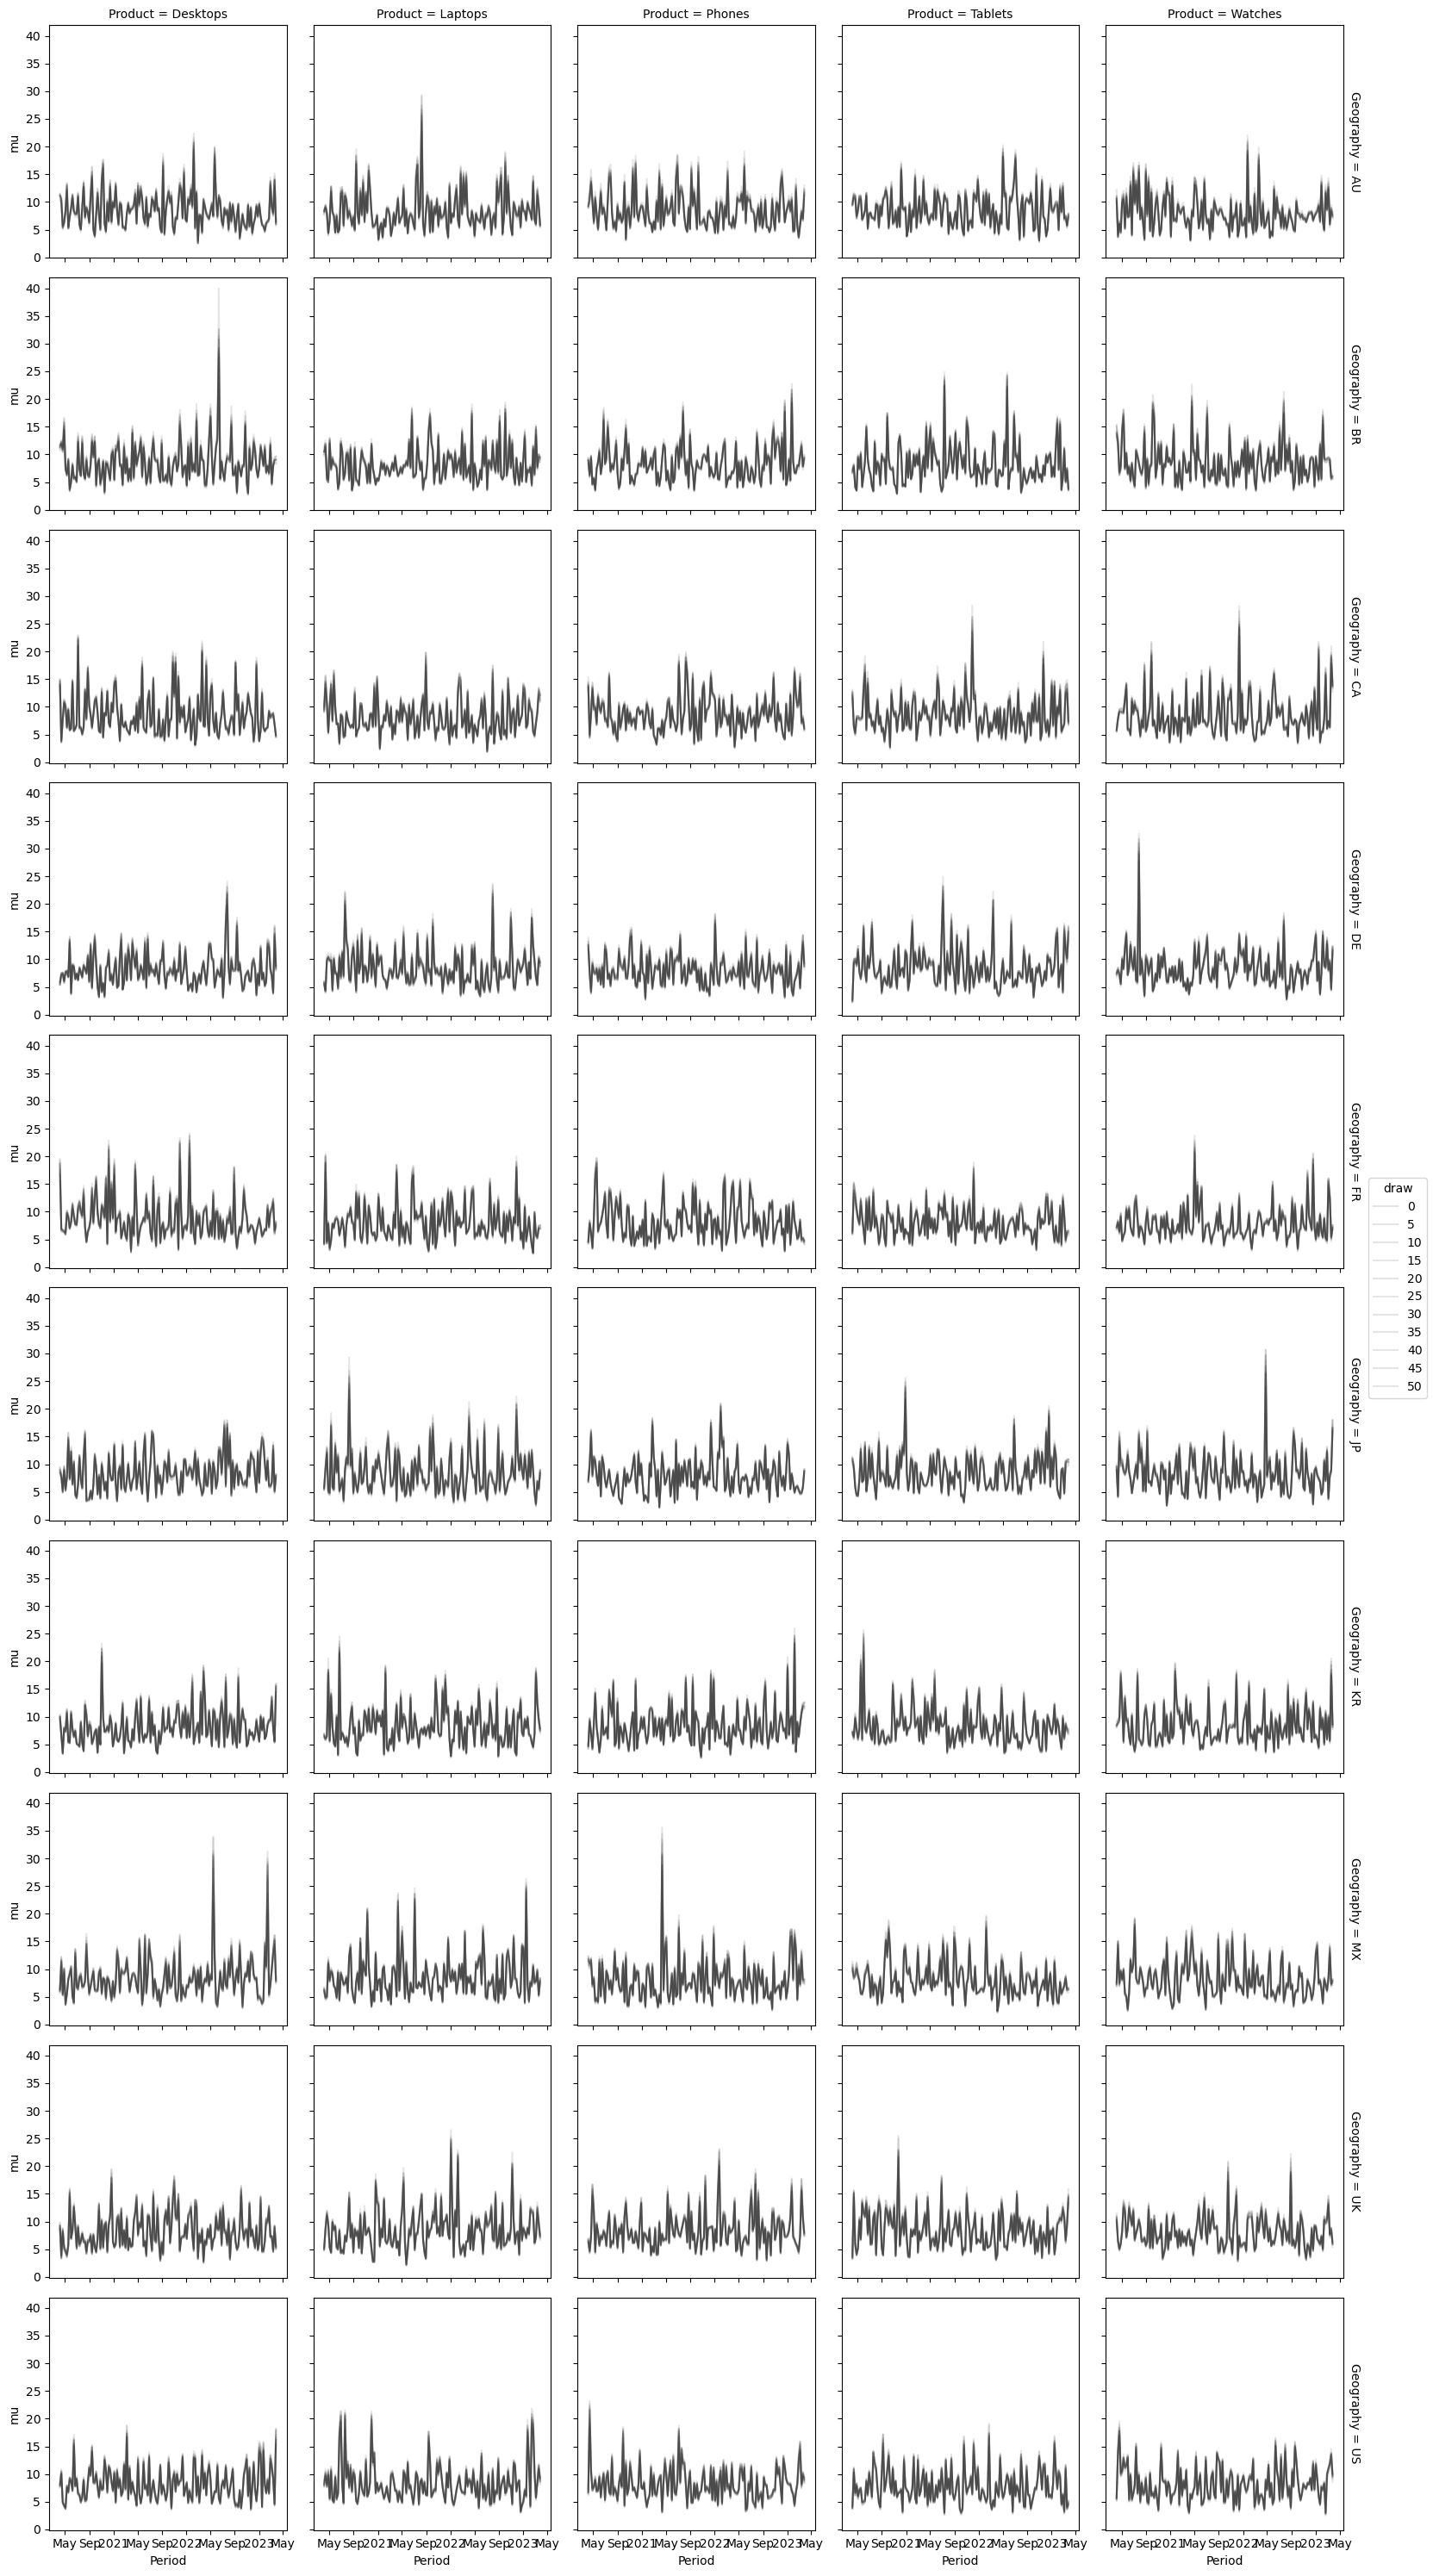

In [15]:
model.trace.posterior.mu.sel(chain=0, draw=slice(0, 50, 5)).plot(
    x="Period", col="Product", row="Geography", hue="draw", color="k", alpha=0.1
)

In [16]:
data = xr.DataArray(
    np.random.geometric(0.5, size=(50, 156)) - 1,
    coords=[
        ("geographies", np.arange(50)),
        ("date", pd.date_range("2021-01-01", periods=156, freq="W-MON")),
    ],
    dims=["geographies", "date"],
)
data

<xarray.DataArray (geographies: 50, date: 156)> Size: 62kB
array([[1, 0, 0, ..., 0, 0, 0],
       [0, 2, 1, ..., 2, 0, 5],
       [1, 2, 0, ..., 2, 0, 0],
       ...,
       [3, 1, 1, ..., 0, 2, 0],
       [3, 2, 0, ..., 0, 0, 2],
       [1, 1, 0, ..., 2, 0, 0]])
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25

In [17]:
data.coords.items()

ItemsView(Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25)

In [18]:
with pm.Model(coords={k: v for k, v in data.coords.items()}) as model:
    constant_data = pm.Data("constant_data", data, dims=data.dims)

In [19]:
xr.Dataset.from_dataframe(data.to_dataframe("Geom"))

<xarray.Dataset> Size: 64kB
Dimensions:      (geographies: 50, date: 156)
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25
Data variables:
    Geom         (geographies, date) int64 62kB 1 0 0 1 0 0 6 ... 1 1 0 2 2 0 0

In [20]:
data.where(data > 0).median(dim="date")

<xarray.DataArray (geographies: 50)> Size: 400B
array([2. , 1. , 1. , 1. , 2. , 2. , 2. , 1. , 1. , 2. , 2. , 1. , 1. ,
       2. , 1. , 2. , 2. , 1. , 2. , 2. , 2. , 2. , 1. , 1. , 1.5, 1. ,
       2. , 2. , 1. , 2. , 1. , 1. , 1. , 2. , 2. , 1. , 2. , 1. , 1. ,
       2. , 1. , 1. , 2. , 2. , 1. , 2. , 1. , 1. , 2. , 2. ])
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49

In [24]:
contritributions = model.get_contributions()

In [25]:
contritributions.head()

,Geography,Product,Period,intercept_contribution,Promotion_Total_Total_Total_contribution,media_var_0_Total_Total_Total_contribution,LLT_contribution,annual_seasonality_contribution
0,AU,Desktops,2020-04-06,2.019209,0.379404,0.004860,0.001088,-0.008957
1,AU,Desktops,2020-04-13,2.019209,0.264828,0.034473,0.000141,-0.005877
2,AU,Desktops,2020-04-20,2.019209,-0.389181,0.026475,-0.000993,-0.002908
3,AU,Desktops,2020-04-27,2.019209,-0.233414,0.013753,-0.002296,-0.000026
4,AU,Desktops,2020-05-04,2.019209,0.078563,0.015177,-0.003749,0.002852


In [26]:
avm = model.avm()

/home/mattr/Scratch/BayesInsight/bayesinsight/models/model.py:291: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior = pm.sample_posterior_predictive(self.trace)
Sampling: [Stock_Total_Total_Total_likelihood]


Output()

In [27]:
avm.head()

,Geography,Product,Period,Stock_Total_Total_Total,Stock_Total_Total_Total_likelihood,mu
0,AU,Desktops,2020-04-06,14.0,10.91625,10.982772
1,AU,Desktops,2020-04-13,5.0,10.11200,10.107826
2,AU,Desktops,2020-04-20,5.0,5.21650,5.223988
3,AU,Desktops,2020-04-27,6.0,6.01275,6.035465
4,AU,Desktops,2020-05-04,10.0,8.33600,8.267470


<Axes: ylabel='Frequency'>

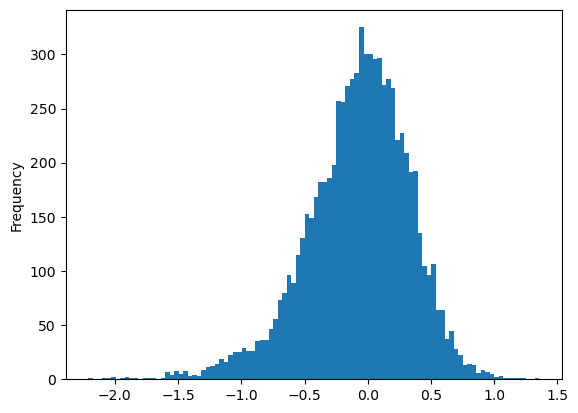